# Optical Constants Prediction Model
# Overview
This notebook implements a forward deep learning model to predict optical parameters like refractive index (`n`), extinction coefficient (`k`), from spectral or material data.


In [1]:
# Reproducibility setup
def set_global_seed(seed=42):
    import os, random, numpy as np, tensorflow as tf
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    try:
        tf.keras.utils.set_random_seed(seed)
        tf.config.experimental.enable_op_determinism()
    except Exception as e:
        print("Optional TF determinism setting skipped:", e)
    print(f"[INFO] Global seed set to {seed}")


set_global_seed(42)


[INFO] Global seed set to 42


In [2]:
# Create results directory 
import os

save_dir = "F:/Project_RINFO/results"
os.makedirs(save_dir, exist_ok=True)

In [3]:
#  Import libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


## STEP 1: Data Loading & Preprocessing
This section loads the dataset, performs feature scaling, and prepares data for model training.

We begin by importing and cleaning the raw optical constants dataset (`nk_data.csv`) to ensure it's usable for machine learning.

### why clean wavelength and remove invalid entries?

- We convert `'Wavelength (µm)'` to numeric to avoid parsing errors during analysis.
- We restrict the data to a physical range (0.2 µm to 1000 µm) to remove extreme outliers or measurement artifacts.
- Optical constants `n` and `k` must be non-negative and physically meaningful. We ensure `k ≥ 0` and `n > 0.1` to exclude noise and invalid records.

## Material Encoding

Each material name is mapped to a unique integer ID using label encoding.

### Why encode materials?

- Neural networks require numerical inputs.
- Embedding the material ID allows the model to **learn a latent representation** of material-dependent behavior, instead of treating material names as categorical text.


In [4]:
# Load dataset
df = pd.read_csv("nk_data.csv")

# Convert wavelength to numeric
df['Wavelength (µm)'] = pd.to_numeric(df['Wavelength (µm)'], errors='coerce')
df = df.dropna(subset=['Wavelength (µm)', 'n', 'k'])

# Filter to valid range
df = df[(df['Wavelength (µm)'] >= 0.2) & (df['Wavelength (µm)'] <= 1000)]
df = df[(df['k'] >= 0) & (df['n'] > 0.1)]


In [5]:
print(df.shape)
df.head()

(485314, 6)


,Material,Dataset,Wavelength (µm),n,k,Wavelength (nm)
0,Ag,Ciesielski-Ge,0.20000,0.99500,1.19600,200.00
1,Ag,Ciesielski-Ni,0.20000,1.06300,1.24200,200.00
2,Ag,Ciesielski,0.20000,1.06300,1.15200,200.00
3,Ag,Stahrenberg,0.20062,1.00116,1.38449,200.62
4,Ag,Ciesielski-Ge,0.20065,0.99800,1.20000,200.65


In [6]:
# Get unique materials
material_list = df['Material'].unique()

# Convert to Python list
material_list = list(material_list)

# Optional: Sort it for easy review
material_list.sort()

# Display or copy
print(material_list)


['Ag', 'Al', 'Al2O3', 'AlAs', 'AlN', 'AlSb', 'As2S3', 'As2Se3', 'Au', 'B4C', 'BN', 'BaF2', 'Be', 'Bi', 'Bi2Se3', 'Bi2Te3', 'BiFeO3', 'C', 'Ca', 'CaF2', 'CaMg(CO3)2', 'CaSO4', 'CdS', 'CdSe', 'CdTe', 'Ce', 'CeF3', 'Co', 'Cr', 'Cs', 'CsBr', 'CsI', 'Cu', 'Cu2O', 'D2O', 'DyScO3', 'Er', 'EuS', 'Fe', 'Fe2O3', 'Fe3O4', 'GaAs', 'GaN', 'GaP', 'GaS', 'GaSb', 'GdF3', 'Ge', 'Ge2Sb2Te5', 'GeO2', 'H2O', 'HfO2', 'HfSe2', 'Hg', 'Ho', 'In', 'In2Se3', 'InAs', 'InP', 'InSb', 'Ir', 'K', 'KCl', 'LaAlO3', 'LaF3', 'Li', 'Lu', 'Lu2O3', 'Mg', 'MgAl2O4', 'MgF2', 'MgH2', 'MgO', 'Mn', 'MnPSe3', 'Mo', 'MoO3', 'MoS2', 'MoSe2', 'MoTe2', 'Na', 'NaCl', 'Nb', 'Nb2O5', 'NbSe2', 'Ni', 'NiPS3', 'Os', 'Pb', 'PbI2', 'PbSe', 'Pd', 'PdSe2', 'Pr', 'Pt', 'PtS2', 'PtSe2', 'Rb', 'ReS2', 'Rh', 'Sc2O3', 'ScAlMgO4', 'Se', 'Si', 'Si3N4', 'SiC', 'SiO2', 'Sn', 'SnS2', 'SnSe', 'SnSe2', 'Sr', 'SrF2', 'SrTiO3', 'Ta', 'Ta2O5', 'TaS2', 'TaSe2', 'Tb3Ga5O12', 'Te', 'Ti', 'Ti3C2', 'TiC', 'TiH2', 'TiN', 'TiO2', 'Tm', 'V', 'VC', 'VN', 'VO2', 'W',

In [7]:
material_groups = {
    'metal': [
        'Ag', 'Al', 'Au', 'Be', 'Bi', 'Ca', 'Cd', 'Ce', 'Co', 'Cr', 'Cs', 'Cu', 'Dy',
        'Er', 'EuS', 'Fe', 'Ga', 'Gd', 'Hg', 'Ho', 'In', 'Ir', 'K', 'La', 'Li', 'Lu',
        'Mg', 'Mn', 'Mo', 'Na', 'Nb', 'Ni', 'Os', 'Pb', 'Pd', 'Pr', 'Pt', 'Rb', 'Re',
        'Rh', 'Sc', 'Sn', 'Sr', 'Ta', 'Tb', 'Te', 'Ti', 'Tm', 'V', 'W', 'Yb', 'Zn', 'Zr'
    ],
    'oxide': [
        'Al2O3', 'BiFeO3', 'CaMg(CO3)2', 'CaSO4', 'Cu2O', 'Fe2O3', 'Fe3O4', 'GeO2',
        'H2O', 'HfO2', 'LaAlO3', 'Lu2O3', 'MgO', 'MoO3', 'Nb2O5', 'Sc2O3',
        'SiO2', 'SrTiO3', 'Ta2O5', 'TiO2', 'VO2', 'WO3', 'Y3Al5O12', 'ZrO2'
    ],
    'nitride': [
        'AlN', 'BN', 'GaN', 'Si3N4', 'TiN', 'VN'
    ],
    'semiconductor': [
        'AlAs', 'AlSb', 'As2S3', 'As2Se3', 'Bi2Se3', 'Bi2Te3', 'CdS', 'CdSe', 'CdTe',
        'GaAs', 'GaP', 'GaSb', 'Ge', 'Ge2Sb2Te5', 'In2Se3', 'InAs', 'InP', 'InSb',
        'MoS2', 'MoSe2', 'MoTe2', 'NbSe2', 'PbSe', 'PdSe2', 'PtS2', 'PtSe2', 'ReS2',
        'Si', 'SiC', 'SnS2', 'SnSe', 'SnSe2', 'TaS2', 'TaSe2', 'WS2', 'WSe2', 'WTe2',
        'ZnO', 'ZnS', 'ZnSe', 'ZnTe', 'ZrSe2', 'ZrTe5'
    ],
    'dielectric': [
        'BaF2', 'CaF2', 'CeF3', 'GdF3', 'KCl', 'LaF3', 'MgF2', 'NaCl', 'Si3N4', 'SrF2'
    ],
    'other': [  # Remaining materials (composites, carbides, hydrides, water, etc.)
        'B4C', 'D2O', 'MgH2', 'MnPSe3', 'NiPS3', 'ScAlMgO4', 'Se', 'Ti3C2', 'TiC', 'TiH2', 'VC'
    ]
}


In [8]:
# Reverse map from material to group
material_to_group = {}
for group, materials in material_groups.items():
    for mat in materials:
        material_to_group[mat] = group

# Apply group to DataFrame
df['material_group'] = df['Material'].map(material_to_group).fillna('other')


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get counts
group_counts = df['material_group'].value_counts()
group_percent = df['material_group'].value_counts(normalize=True) * 100

# 2. Combine into a single DataFrame
group_dist = pd.DataFrame({
    'Count': group_counts,
    'Percentage': group_percent.round(2)
})

print(" Material Group Distribution:\n")
group_dist

 Material Group Distribution:



,Count,Percentage
material_group,,
semiconductor,184448,38.01
oxide,124866,25.73
other,88671,18.27
metal,41546,8.56
dielectric,34772,7.16
nitride,11011,2.27


C:\Users\hp\AppData\Local\Temp\ipykernel_15520\4025890449.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Saved: F:/Project_RINFO/results\material_group_distribution_bar.png, F:/Project_RINFO/results\material_group_distribution_bar.tiff


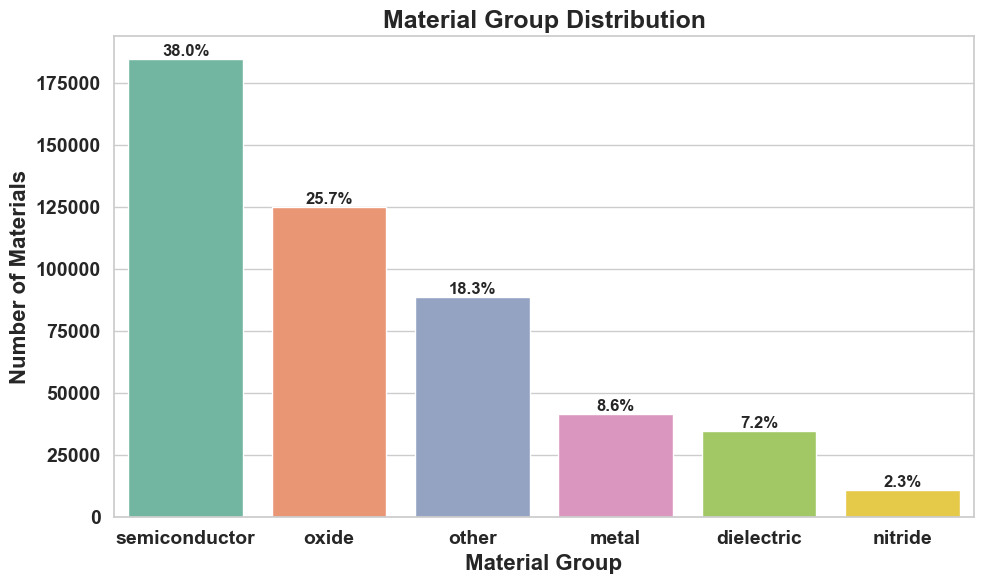

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os

def plot_bar_matplotlib(group_dist, save_path, filename_base="material_group_distribution"):
    """
    Plots a bar chart of material group distribution and saves as PNG and TIFF (with bold labels).
    """
    os.makedirs(save_dir, exist_ok=True)

    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")

    group_dist_sorted = group_dist.sort_values("Count", ascending=False)

    ax = sns.barplot(
        x=group_dist_sorted.index,
        y="Count",
        data=group_dist_sorted,
        palette="Set2"
    )

    # Add bold % text on top of each bar
    for i, (count, pct) in enumerate(zip(group_dist_sorted["Count"], group_dist_sorted["Percentage"])):
        ax.text(i, count + 1, f"{pct:.1f}%", ha='center', va='bottom',
                fontsize=12, fontweight='bold')

    # Bold title and axis labels
    plt.title("Material Group Distribution", fontsize=18, fontweight='bold')
    plt.ylabel("Number of Materials", fontsize=16, fontweight='bold')
    plt.xlabel("Material Group", fontsize=16, fontweight='bold')

    # Bold tick labels
    ax.tick_params(axis='x', labelrotation=0, labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.tight_layout()

    # Save PNG + TIFF
    png_path = os.path.join(save_dir, f"{filename_base}_bar.png")
    tiff_path = os.path.join(save_dir, f"{filename_base}_bar.tiff")
    plt.savefig(png_path, dpi=300)
    Image.open(png_path).save(tiff_path, format="TIFF")
    print(f"Saved: {png_path}, {tiff_path}")

    plt.show()



save_path = os.path.join(save_dir, "material_data_distribution")    
plot_bar_matplotlib(group_dist, save_dir)

In [13]:
print('______Shape_____', df.shape)
df.head()

______Shape_____ (485314, 7)


,Material,Dataset,Wavelength (µm),n,k,Wavelength (nm),material_group
0,Ag,Ciesielski-Ge,0.20000,0.99500,1.19600,200.00,metal
1,Ag,Ciesielski-Ni,0.20000,1.06300,1.24200,200.00,metal
2,Ag,Ciesielski,0.20000,1.06300,1.15200,200.00,metal
3,Ag,Stahrenberg,0.20062,1.00116,1.38449,200.62,metal
4,Ag,Ciesielski-Ge,0.20065,0.99800,1.20000,200.65,metal


In [14]:
df_Rinfo = df
df_Rinfo

,Material,Dataset,Wavelength (µm),n,k,Wavelength (nm),material_group
0,Ag,Ciesielski-Ge,0.20000,0.99500,1.19600,200.00,metal
1,Ag,Ciesielski-Ni,0.20000,1.06300,1.24200,200.00,metal
2,Ag,Ciesielski,0.20000,1.06300,1.15200,200.00,metal
3,Ag,Stahrenberg,0.20062,1.00116,1.38449,200.62,metal
4,Ag,Ciesielski-Ge,0.20065,0.99800,1.20000,200.65,metal
...,...,...,...,...,...,...,...
487872,ZrTe5,Guo-beta,1.29750,1.30185,0.04957,1297.50,semiconductor
487873,ZrTe5,Guo-gamma,1.29750,3.32466,3.36385,1297.50,semiconductor
487874,ZrTe5,Guo-alpha,1.30000,2.64214,3.47317,1300.00,semiconductor
487875,ZrTe5,Guo-beta,1.30000,1.30172,0.04948,1300.00,semiconductor


In [15]:
# Encode material name to ID
materials = sorted(df_Rinfo['Material'].unique())
material_to_id = {mat: idx for idx, mat in enumerate(materials)}
df_Rinfo['material_id'] = df_Rinfo['Material'].map(material_to_id)

In [16]:
#  Material ID Verification
print("\n=== Material ID Consistency Check ===")
id_check = df_Rinfo[['Material', 'material_id']].drop_duplicates()
id_check.sort_values('Material').head()


=== Material ID Consistency Check ===


,Material,material_id
0,Ag,0
7039,Al,1
8965,Al2O3,2
13448,AlAs,3
13648,AlN,4


In [17]:
# To check the values in each material_id

vc = df_Rinfo['material_id'].value_counts()
low_freq_ids = vc[vc < 5000].index
filtered_df = df_Rinfo[df_Rinfo['material_id'].isin(low_freq_ids)]
D1 = dict(df_Rinfo['material_id'].value_counts())
print(D1)


{50: 63949, 118: 60232, 103: 45401, 77: 26293, 46: 22832, 17: 18998, 134: 17354, 130: 13230, 133: 11906, 106: 11197, 92: 9801, 78: 7870, 8: 7661, 136: 6603, 14: 6365, 125: 5709, 0: 5682, 124: 5139, 83: 4654, 4: 4481, 2: 4445, 48: 4250, 96: 4117, 60: 4053, 47: 3709, 70: 3323, 51: 3238, 94: 3235, 109: 3231, 95: 3056, 108: 3001, 110: 3001, 146: 2763, 58: 2747, 104: 2586, 115: 2395, 101: 2154, 120: 2069, 91: 1957, 84: 1954, 98: 1954, 117: 1954, 116: 1954, 135: 1954, 1: 1925, 43: 1858, 139: 1832, 112: 1718, 11: 1630, 76: 1609, 32: 1574, 23: 1500, 131: 1475, 28: 1468, 19: 1401, 22: 1391, 7: 1354, 85: 1339, 41: 1339, 39: 1219, 12: 1200, 21: 1148, 10: 1096, 24: 1083, 37: 1081, 67: 1067, 79: 1065, 15: 1051, 5: 1045, 121: 1031, 89: 1001, 143: 991, 140: 811, 145: 804, 44: 804, 52: 804, 141: 778, 20: 752, 38: 750, 45: 746, 59: 746, 127: 725, 16: 700, 68: 696, 123: 685, 71: 670, 40: 612, 49: 571, 75: 504, 142: 500, 90: 500, 100: 486, 119: 482, 88: 427, 9: 419, 86: 402, 56: 402, 74: 402, 64: 395, 6:

In [18]:
# Encode material_group (target)

from sklearn.preprocessing import StandardScaler, LabelEncoder

le = LabelEncoder()
df_Rinfo['group_id'] = le.fit_transform(df_Rinfo['material_group'])  # 0 to 5
df_Rinfo

,Material,Dataset,Wavelength (µm),n,k,Wavelength (nm),material_group,material_id,group_id
0,Ag,Ciesielski-Ge,0.20000,0.99500,1.19600,200.00,metal,0,1
1,Ag,Ciesielski-Ni,0.20000,1.06300,1.24200,200.00,metal,0,1
2,Ag,Ciesielski,0.20000,1.06300,1.15200,200.00,metal,0,1
3,Ag,Stahrenberg,0.20062,1.00116,1.38449,200.62,metal,0,1
4,Ag,Ciesielski-Ge,0.20065,0.99800,1.20000,200.65,metal,0,1
...,...,...,...,...,...,...,...,...,...
487872,ZrTe5,Guo-beta,1.29750,1.30185,0.04957,1297.50,semiconductor,146,5
487873,ZrTe5,Guo-gamma,1.29750,3.32466,3.36385,1297.50,semiconductor,146,5
487874,ZrTe5,Guo-alpha,1.30000,2.64214,3.47317,1300.00,semiconductor,146,5
487875,ZrTe5,Guo-beta,1.30000,1.30172,0.04948,1300.00,semiconductor,146,5


In [19]:
df_Rinfo['group_id'].value_counts()

group_id
5    184448
4    124866
3     88671
1     41546
0     34772
2     11011
Name: count, dtype: int64

In [21]:
# Save mappings
import joblib

with open(os.path.join(save_dir, "material_to_group.json"), "w") as f:
    json.dump(material_to_group, f)

with open(os.path.join(save_dir, "material_to_id.json"), "w") as f:
    json.dump(material_to_id, f)

joblib.dump(le, "F:/Project_RINFO/saved_models/group_label_encoder.pkl")

print("All mapping dictionaries saved to:", save_dir)

All mapping dictionaries saved to: F:/Project_RINFO/results


In [22]:
group_counts = df_Rinfo.groupby(['group_id', 'material_group']).size().reset_index(name='count')
group_counts


,group_id,material_group,count
0,0,dielectric,34772
1,1,metal,41546
2,2,nitride,11011
3,3,other,88671
4,4,oxide,124866
5,5,semiconductor,184448


In [23]:
df_Rinfo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 485314 entries, 0 to 487876
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Material         485314 non-null  object 
 1   Dataset          485314 non-null  object 
 2   Wavelength (µm)  485314 non-null  float64
 3   n                485314 non-null  float64
 4   k                485314 non-null  float64
 5   Wavelength (nm)  485314 non-null  float64
 6   material_group   485314 non-null  object 
 7   material_id      485314 non-null  int64  
 8   group_id         485314 non-null  int32  
dtypes: float64(4), int32(1), int64(1), object(3)
memory usage: 35.2+ MB


In [24]:
df_Rinfo['material_id'].value_counts()

material_id
50     63949
118    60232
103    45401
77     26293
46     22832
       ...  
93         5
111        4
36         4
137        1
25         1
Name: count, Length: 147, dtype: int64

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Select features and targets
X = df_Rinfo[['Wavelength (µm)', 'material_id', 'group_id']]
y_n = df_Rinfo['n']
y_k = df_Rinfo['k']


In [26]:
# Train-test split
X_train, X_test, y_n_train, y_n_test, y_k_train, y_k_test = train_test_split(
    X, y_n, y_k, test_size=0.2, random_state=42
)

In [27]:
from sklearn.preprocessing import StandardScaler

# Scale wavelength
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled['Wavelength (µm)'] = scaler.fit_transform(X_train[['Wavelength (µm)']])
X_test_scaled['Wavelength (µm)'] = scaler.transform(X_test[['Wavelength (µm)']])

In [28]:
import joblib
joblib.dump(scaler, 'F:/Project_RINFO/saved_models/wavelength_scaler.pkl')


['F:/Project_RINFO/saved_models/wavelength_scaler.pkl']

XGBoost Model

In [30]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Refit models without validation arguments
xgb_n = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
xgb_k = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)

xgb_n.fit(X_train_scaled, y_n_train)
xgb_k.fit(X_train_scaled, y_k_train)

# Predict
y_n_pred = xgb_n.predict(X_test_scaled)
y_k_pred = xgb_k.predict(X_test_scaled)

# Evaluate
print("Test Set Metrics:")
print(f"n → RMSE: {np.sqrt(mean_squared_error(y_n_test, y_n_pred)):.4f}, R²: {r2_score(y_n_test, y_n_pred):.4f}")
print(f"k → RMSE: {np.sqrt(mean_squared_error(y_k_test, y_k_pred)):.4f}, R²: {r2_score(y_k_test, y_k_pred):.4f}")

Test Set Metrics:
n → RMSE: 1.0708, R²: 0.9846
k → RMSE: 1.7042, R²: 0.9817


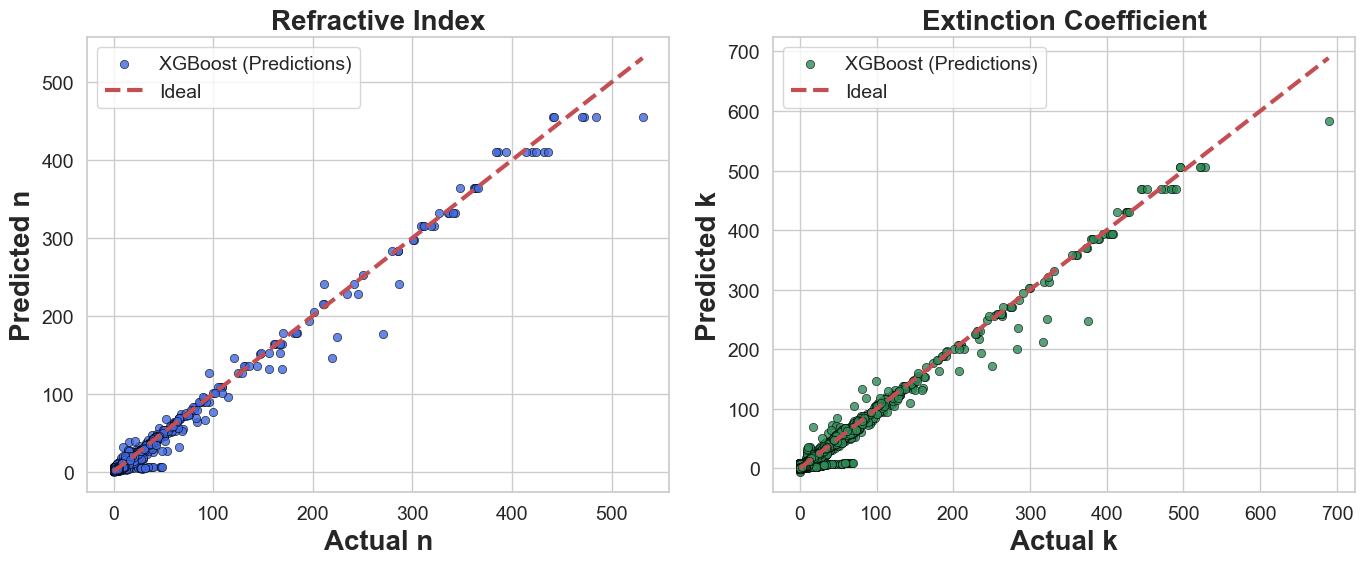

✅ Figure saved at: F:\Project_RINFO\results\xgboost_results.png


In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Model name
model_name = "XGBoost"

# Set global style
sns.set(style="whitegrid", font_scale=1.5)

plt.figure(figsize=(14, 6))

# n plot (blue)
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=y_n_test, y=y_n_pred,
    color='royalblue', alpha=0.8, edgecolor='black',
    label=f"{model_name} (Predictions)"
)
plt.plot(
    [y_n_test.min(), y_n_test.max()],
    [y_n_test.min(), y_n_test.max()],
    'r--', lw=3, label=f"Ideal"
)
plt.xlabel("Actual n", fontsize=20, fontweight='bold')
plt.ylabel("Predicted n", fontsize=20, fontweight='bold')
plt.title("Refractive Index", fontsize=20, fontweight='bold')
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14, width=2)

# k plot (green)
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=y_k_test, y=y_k_pred,
    color='seagreen', alpha=0.8, edgecolor='black',
    label=f"{model_name} (Predictions)"
)
plt.plot(
    [y_k_test.min(), y_k_test.max()],
    [y_k_test.min(), y_k_test.max()],
    'r--', lw=3, label=f"Ideal"
)
plt.xlabel("Actual k", fontsize=20, fontweight='bold')
plt.ylabel("Predicted k", fontsize=20, fontweight='bold')
plt.title("Extinction Coefficient", fontsize=20, fontweight='bold')
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14, width=2)

plt.tight_layout()

# Save figure
save_path = rf"F:\Project_RINFO\results\{model_name.lower()}_results.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()
print(f"✅ Figure saved at: {save_path}")


### Step 2: Define Loss and Build Model
- Material embedding lets the model learn shared optical behavior across materials.

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense

# Get unique counts
num_materials = df_Rinfo['material_id'].nunique()
num_groups = df_Rinfo['group_id'].nunique()

def build_mlp():
    # Inputs
    wavelength_input = Input(shape=(1,), name='wavelength')
    material_input = Input(shape=(1,), name='material_id')
    group_input = Input(shape=(1,), name='group_id')

    # Named embeddings
    material_embed = Embedding(input_dim=num_materials, output_dim=12, name='material_embedding')(material_input)
    group_embed = Embedding(input_dim=num_groups, output_dim=8, name='group_embedding')(group_input)

    # Flatten
    material_flat = Flatten()(material_embed)
    group_flat = Flatten()(group_embed)

    # Concatenate
    x = Concatenate()([wavelength_input, material_flat, group_flat])

    # Dense layers
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)

    # Outputs
    n_out = Dense(1, name='n_output')(x)
    k_out = Dense(1, name='k_output')(x)

    return Model(
        inputs=[wavelength_input, material_input, group_input],
        outputs=[n_out, k_out]
    )


In [33]:
import tensorflow as tf
from tensorflow.keras.models import Model

def reflectance_loss(n_pred, k_pred):
    numerator = tf.square(n_pred - 1.0) + tf.square(k_pred)
    denominator = tf.square(n_pred + 1.0) + tf.square(k_pred)
    R_pred = numerator / (denominator + 1e-8)
    return tf.reduce_mean(R_pred)

class ReflectanceModel(Model):
    def __init__(self, base_model, lambda_refl=0.0):
        super().__init__()
        self.base_model = base_model
        self.lambda_refl = lambda_refl
        self.loss_fn = tf.keras.losses.MeanSquaredError()
        self.n_metric = tf.keras.metrics.MeanAbsoluteError(name='n_output_mae')
        self.k_metric = tf.keras.metrics.MeanAbsoluteError(name='k_output_mae')
        self.total_loss_tracker = tf.keras.metrics.Mean(name='loss')

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        x, y = data
        y_n_true = y['n_output']
        y_k_true = y['k_output']

        with tf.GradientTape() as tape:
            y_n_pred, y_k_pred = self.base_model(x, training=True)
            loss_n = self.loss_fn(y_n_true, y_n_pred)
            loss_k = self.loss_fn(y_k_true, y_k_pred)
            refl = reflectance_loss(y_n_pred, y_k_pred)
            total_loss = loss_n + loss_k + self.lambda_refl * refl

        grads = tape.gradient(total_loss, self.base_model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.base_model.trainable_weights))

        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.n_metric.update_state(y_n_true, y_n_pred)
        self.k_metric.update_state(y_k_true, y_k_pred)

        return {
            "loss": self.total_loss_tracker.result(),
            "n_output_mae": self.n_metric.result(),
            "k_output_mae": self.k_metric.result(),
        }

    def test_step(self, data):
        x, y = data
        y_n_true = y['n_output']
        y_k_true = y['k_output']

        y_n_pred, y_k_pred = self.base_model(x, training=False)
        loss_n = self.loss_fn(y_n_true, y_n_pred)
        loss_k = self.loss_fn(y_k_true, y_k_pred)
        refl = reflectance_loss(y_n_pred, y_k_pred)
        total_loss = loss_n + loss_k + self.lambda_refl * refl

        self.total_loss_tracker.update_state(total_loss)
        self.n_metric.update_state(y_n_true, y_n_pred)
        self.k_metric.update_state(y_k_true, y_k_pred)

        return {
            "loss": self.total_loss_tracker.result(),
            "n_output_mae": self.n_metric.result(),
            "k_output_mae": self.k_metric.result(),
        }

    def call(self, inputs):
        return self.base_model(inputs)

    def reset_metrics(self):
        self.total_loss_tracker.reset_state()
        self.n_metric.reset_state()
        self.k_metric.reset_state()


In [34]:
base_model = build_mlp()
model = ReflectanceModel(base_model, lambda_refl=0.0)
model.base_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ material_id (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ group_id (InputLayer)         │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ material_embedding            │ (None, 1, 12)             │           1,764 │ material_id[0][0]          │
│ (Embedding)                   │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ group_embedding (Embedding)   │ (None, 1, 8)              │              48 │ group_id[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ wavelength (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 12)                │               0 │ material_embedding[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 8)                 │               0 │ group_embedding[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 21)                │               0 │ wavelength[0][0],          │
│                               │                           │                 │ flatten[0][0],             │
│                               │                           │                 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │           1,408 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │           4,160 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 32)                │           2,080 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ n_output (Dense)              │ (None, 1)                 │              33 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ k_output (Dense)              │ (None, 1)                 │              33 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 9,526 (37.21 KB)

 Trainable params: 9,526 (37.21 KB)

 Non-trainable params: 0 (0.00 B)

### Compile and Train the Model
- Early stopping or validation split helps avoid overfitting.


In [35]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Choose whether to use reflectance loss
use_combined_loss = True  # Set to False for standard MSE loss
lambda_refl_value = 0.0   # Change later if needed

# Build the base model
base_model = build_mlp()

# Decide model type based on loss choice
if use_combined_loss:
    print("Using custom combined loss with reflectance term.")
    
    # Wrap in custom model for reflectance handling
    model = ReflectanceModel(base_model, lambda_refl=lambda_refl_value)
    
    # Only pass optimizer — no loss or metrics
    model.compile(optimizer=Adam(0.001))

    # Output targets in dict form
    y_train_target = {
        'n_output': y_n_train,
        'k_output': y_k_train
    }

else:
    print("Using standard per-output MSE loss.")
    
    model = base_model
    model.compile(
        optimizer=Adam(0.001),
        loss={'n_output': 'mse', 'k_output': 'mse'},
        metrics={'n_output': 'mae', 'k_output': 'mae'}
    )

    y_train_target = {
        'n_output': y_n_train,
        'k_output': y_k_train
    }

# Prepare input tensors
X_train_tensor = {
    'wavelength': X_train_scaled['Wavelength (µm)'].values.reshape(-1, 1),
    'material_id': X_train_scaled['material_id'].values.reshape(-1, 1),
    'group_id': X_train_scaled['group_id'].values.reshape(-1, 1)
}

X_test_tensor = {
    'wavelength': X_test_scaled['Wavelength (µm)'].values.reshape(-1, 1),
    'material_id': X_test_scaled['material_id'].values.reshape(-1, 1),
    'group_id': X_test_scaled['group_id'].values.reshape(-1, 1)
}

# Early stopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

# Train
history = model.fit(
    X_train_tensor,
    y_train_target,
    validation_split=0.1,
    epochs=100,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)


Using custom combined loss with reflectance term.
Epoch 1/100
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - k_output_mae: 1.4801 - loss: 75.8197 - n_output_mae: 1.1098 - val_k_output_mae: 0.8086 - val_loss: 5.9243 - val_n_output_mae: 0.5852
Epoch 2/100
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - k_output_mae: 0.7538 - loss: 6.4338 - n_output_mae: 0.5742 - val_k_output_mae: 0.6608 - val_loss: 4.1913 - val_n_output_mae: 0.5037
Epoch 3/100
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - k_output_mae: 0.7015 - loss: 5.4089 - n_output_mae: 0.5268 - val_k_output_mae: 0.6814 - val_loss: 3.9229 - val_n_output_mae: 0.4761
Epoch 4/100
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - k_output_mae: 0.6886 - loss: 5.0818 - n_output_mae: 0.5101 - val_k_output_mae: 0.7080 - val_loss: 3.7741 - val_n_output_mae: 0.4628
Epoch 5/100
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - k_output_mae: 0.6750 - loss: 4.6464 - n_output_mae: 0.4948 - val_k_output_mae: 0.7092 - val_loss: 3.7426 - val_n_output_mae: 0.4532
Epo

In [36]:
import os

# Create save directory
model_save_path = "F:/Project_RINFO/saved_models"
os.makedirs(model_save_path, exist_ok=True)

if use_combined_loss:
    # Ensure the ReflectanceModel is built before saving weights
    _ = model(X_train_tensor)

    # Save ReflectanceModel weights and the base_model
    model.save_weights(os.path.join(model_save_path, "reflectance_model.weights.h5"))
    base_model.save(os.path.join(model_save_path, "base_model.keras"))  # Use .keras extension

    print("Custom ReflectanceModel weights and base model saved.")
else:
    # Save the full standard model directly (includes structure + weights)
    model.save(os.path.join(model_save_path, "standard_model.keras"))  # Use .keras extension
    print("Standard model saved.")


Custom ReflectanceModel weights and base model saved.


In [37]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd

# Predict on train set
y_n_pred_train, y_k_pred_train = model.predict(X_train_tensor)
y_n_pred_train = y_n_pred_train.flatten()
y_k_pred_train = y_k_pred_train.flatten()

# Predict on test set
y_n_pred_test, y_k_pred_test = model.predict(X_test_tensor)
y_n_pred_test = y_n_pred_test.flatten()
y_k_pred_test = y_k_pred_test.flatten()

# Compute metrics
def get_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    return rmse, r2, mae

# Train metrics
n_rmse_tr, n_r2_tr, n_mae_tr = get_metrics(y_n_train, y_n_pred_train)
k_rmse_tr, k_r2_tr, k_mae_tr = get_metrics(y_k_train, y_k_pred_train)

# Test metrics
n_rmse_te, n_r2_te, n_mae_te = get_metrics(y_n_test, y_n_pred_test)
k_rmse_te, k_r2_te, k_mae_te = get_metrics(y_k_test, y_k_pred_test)

# Create combined DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'R²', 'MAE'],
    'n_train': [n_rmse_tr, n_r2_tr, n_mae_tr],
    'n_test':  [n_rmse_te, n_r2_te, n_mae_te],
    'k_train': [k_rmse_tr, k_r2_tr, k_mae_tr],
    'k_test':  [k_rmse_te, k_r2_te, k_mae_te]
})

metrics_df


12133/12133 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


,Metric,n_train,n_test,k_train,k_test
0,RMSE,0.792872,0.843652,1.398965,1.501786
1,R²,0.991078,0.990465,0.987611,0.985756
2,MAE,0.319307,0.320563,0.425584,0.423064


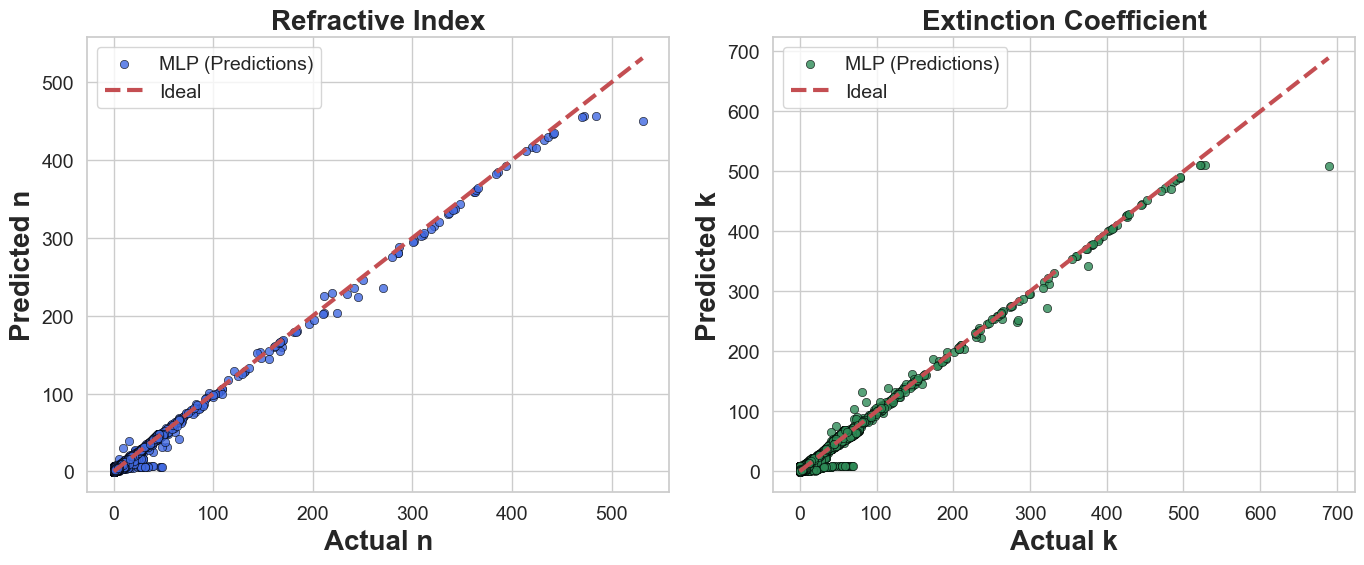

✅ Figure saved at: F:\Project_RINFO\results\mlp_results.png


In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Model name
model_name = "MLP"

# Set global style
sns.set(style="whitegrid", font_scale=1.5)

plt.figure(figsize=(14, 6))

# n plot (blue)
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=y_n_test, y=y_n_pred_test,
    color='royalblue', alpha=0.8, edgecolor='black',
    label=f"{model_name} (Predictions)"
)
plt.plot(
    [y_n_test.min(), y_n_test.max()],
    [y_n_test.min(), y_n_test.max()],
    'r--', lw=3, label="Ideal"
)
plt.xlabel("Actual n", fontsize=20, fontweight='bold')
plt.ylabel("Predicted n", fontsize=20, fontweight='bold')
plt.title("Refractive Index", fontsize=20, fontweight='bold')
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14, width=2)

# k plot (green)
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=y_k_test, y=y_k_pred_test,
    color='seagreen', alpha=0.8, edgecolor='black',
    label=f"{model_name} (Predictions)"
)
plt.plot(
    [y_k_test.min(), y_k_test.max()],
    [y_k_test.min(), y_k_test.max()],
    'r--', lw=3, label="Ideal"
)
plt.xlabel("Actual k", fontsize=20, fontweight='bold')
plt.ylabel("Predicted k", fontsize=20, fontweight='bold')
plt.title("Extinction Coefficient", fontsize=20, fontweight='bold')
plt.legend(fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14, width=2)

plt.tight_layout()

# Save figure
save_path = rf"F:\Project_RINFO\results\{model_name.lower()}_results.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()
print(f"✅ Figure saved at: {save_path}")


Material embedding shape: (147, 12)
Group embedding shape: (6, 8)
Saved to: F:/Project_RINFO/results/combined_embeddings_tsne.png


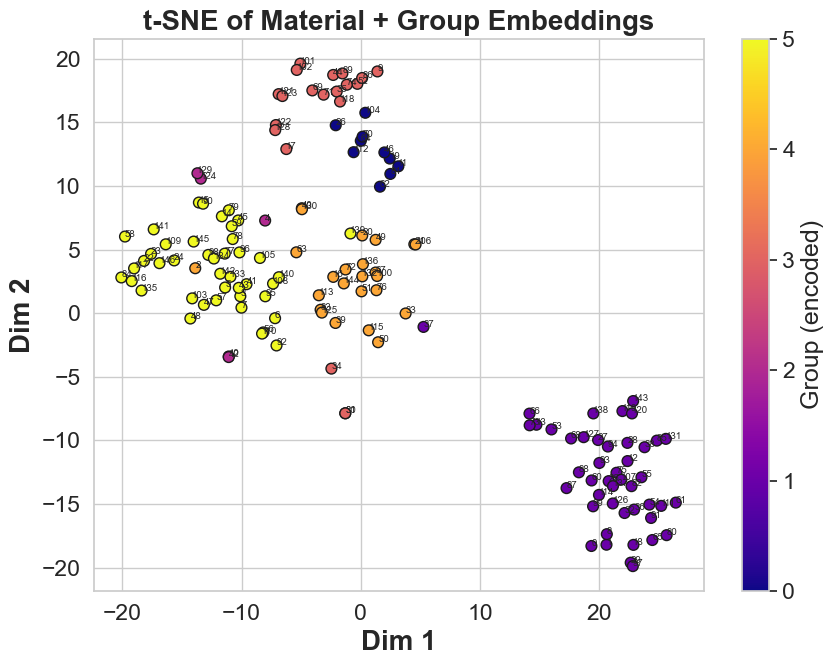

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder


def visualize_combined_embeddings(base_model, df, save_path=None):
    """
    Visualizes the combined material + group embeddings using t-SNE.

    Args:
        base_model: The trained Keras model with 'material_embedding' and 'group_embedding'.
        df: DataFrame with 'material_id' and 'group_id' columns.
        save_path: Optional path to save the PNG plot.
    """
    # 1. Get embedding weights
    material_embeddings = base_model.get_layer("material_embedding").get_weights()[0]  # (num_materials, 8)
    group_embeddings = base_model.get_layer("group_embedding").get_weights()[0]        # (num_groups, 4)
    print("Material embedding shape:", material_embeddings.shape)
    print("Group embedding shape:", group_embeddings.shape)

    # 2. Map material_id to group_id
    mat_to_group = df_Rinfo.drop_duplicates("material_id").set_index("material_id")["group_id"].to_dict()
    material_ids = sorted(mat_to_group.keys())
    group_ids = [mat_to_group[mid] for mid in material_ids]

    # 3. Combine embeddings: concat(material + group)
    combined_embeddings = np.array([
        np.concatenate([material_embeddings[mid], group_embeddings[gid]])
        for mid, gid in zip(material_ids, group_ids)
    ])

    # 4. t-SNE reduction
    tsne = TSNE(n_components=2, perplexity=15, random_state=42)
    embeddings_2d = tsne.fit_transform(combined_embeddings)

    # 5. Encode group_id to color
    group_encoded = LabelEncoder().fit_transform(group_ids)

    # 6. Plot
    plt.figure(figsize=(9, 7))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=group_encoded, cmap='plasma', s=60, edgecolor='k')

    # Optional: annotate material_id
    for i, mid in enumerate(material_ids):
        plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], str(mid), fontsize=7)

    plt.title("t-SNE of Material + Group Embeddings",fontsize=20, fontweight='bold')
    plt.xlabel("Dim 1", fontsize=20, fontweight='bold')
    plt.ylabel("Dim 2", fontsize=20, fontweight='bold')
    plt.grid(True)
    plt.colorbar(scatter, label='Group (encoded)')
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300)
        print(f"Saved to: {save_path}")

    plt.show()

# Run the function
visualize_combined_embeddings(
    base_model,
    df_Rinfo,
    save_path="F:/Project_RINFO/results/combined_embeddings_tsne.png"
)



In [41]:
from tensorflow.keras.utils import plot_model

# Save model architecture as a PNG
plot_model(
    base_model,
    to_file=os.path.join(save_dir, "forward_model_architecture.png"),
    show_shapes=True,
    show_layer_names=True,
    dpi=300
)

print("Saved model architecture to:", os.path.join(save_dir, "forward_model_architecture.png"))



Saved model architecture to: F:/Project_RINFO/results\forward_model_architecture.png


In [42]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Define reflectance loss strengths
lambda_values = [0.5, 1.0, 5.0, 10.0, 30.0, 50.0, 70.0, 100.0]

# Lists for metrics and dictionary for predictions
results = []
all_preds = {}

# Loop through each lambda_refl
for lambda_refl in lambda_values:
    print(f"\nTraining model with λ_refl = {lambda_refl}")

    # Build model
    base_model = build_mlp()
    model = ReflectanceModel(base_model, lambda_refl=lambda_refl)
    model.compile(optimizer=Adam(0.001))

    # Define targets
    y_train_target = {
        'n_output': y_n_train,
        'k_output': y_k_train
    }

    # Train model
    early_stop = EarlyStopping(patience=10, restore_best_weights=True)
    model.fit(
        X_train_tensor,
        y_train_target,
        validation_split=0.1,
        epochs=100,
        batch_size=128,
        callbacks=[early_stop],
        verbose=0
    )

    # Predict on test set
    y_n_pred, y_k_pred = model.predict(X_test_tensor)
    y_n_pred = y_n_pred.flatten()
    y_k_pred = y_k_pred.flatten()
    y_n_true = y_n_test.to_numpy().flatten()
    y_k_true = y_k_test.to_numpy().flatten()

    # Store predictions and ground truth
    all_preds[lambda_refl] = {
        "y_n_pred": y_n_pred,
        "y_k_pred": y_k_pred,
        "y_n_true": y_n_true,
        "y_k_true": y_k_true
    }

    # Compute metrics
    n_rmse = np.sqrt(mean_squared_error(y_n_true, y_n_pred))
    k_rmse = np.sqrt(mean_squared_error(y_k_true, y_k_pred))

    n_mae = mean_absolute_error(y_n_true, y_n_pred)
    k_mae = mean_absolute_error(y_k_true, y_k_pred)

    n_r2 = r2_score(y_n_true, y_n_pred)
    k_r2 = r2_score(y_k_true, y_k_pred)

    results.append({
        'λ_refl': lambda_refl,
        'n_MAE': n_mae,
        'k_MAE': k_mae,
        'n_RMSE': n_rmse,
        'k_RMSE': k_rmse,
        'n_R²': n_r2,
        'k_R²': k_r2
    })

# Store all results in a DataFrame
results_df = pd.DataFrame(results)

# Display result summary
print("\nSummary of Metrics Across λ_refl:")
print(results_df.to_string(index=False))



Training model with λ_refl = 0.5
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Training model with λ_refl = 1.0
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Training model with λ_refl = 5.0
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

Training model with λ_refl = 10.0
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

Training model with λ_refl = 30.0
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

Training model with λ_refl = 50.0
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

Training model with λ_refl = 70.0
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

Training model with λ_refl = 100.0
3034/3034 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

Summary of Metrics Across λ_refl:
 λ_refl    n_MAE    k_MAE   n_RMSE   k_RMSE     n_R²     k_R²
    0.5 0.319809 0.403343 0.922287 1.444904 0.988605 0.986815
    1.0 0.348852 0.405473 0.864166 1.500082 0.989996 0.985789
    5.0 0.511720 0.498878 0.985488 1.567432 0.986990 0.984484
   10.0 0.611063 0.446311 0.980466 1.453898 0.987122 0.986650
   30.0 1.220666 0.616412 1.56829

In [43]:
results_df

,λ_refl,n_MAE,k_MAE,n_RMSE,k_RMSE,n_R²,k_R²
0,0.5,0.319809,0.403343,0.922287,1.444904,0.988605,0.986815
1,1.0,0.348852,0.405473,0.864166,1.500082,0.989996,0.985789
2,5.0,0.511720,0.498878,0.985488,1.567432,0.986990,0.984484
3,10.0,0.611063,0.446311,0.980466,1.453898,0.987122,0.986650
4,30.0,1.220666,0.616412,1.568292,1.638186,0.967051,0.983051
5,50.0,1.481913,0.742376,1.935260,1.872088,0.949827,0.977866
6,70.0,1.575686,0.817609,2.060036,2.011551,0.943149,0.974445
7,100.0,1.644883,0.880239,2.178523,2.198378,0.936421,0.969478


## Plot MAE vs λ_refl (reflectance loss weight)

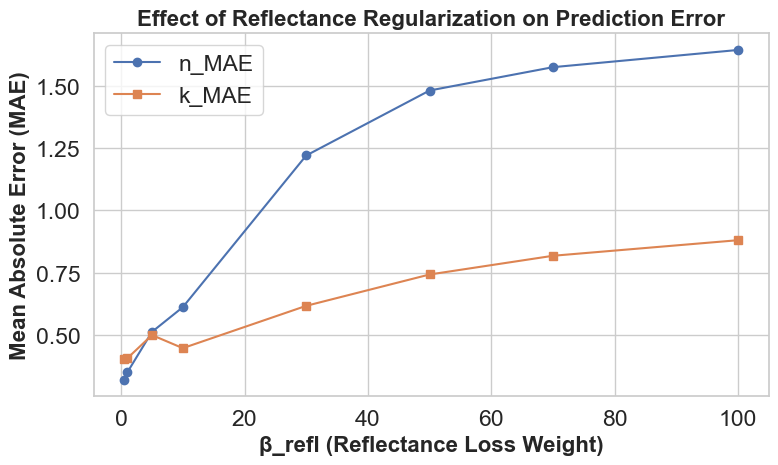

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(results_df['λ_refl'], results_df['n_MAE'], label='n_MAE', marker='o')
plt.plot(results_df['λ_refl'], results_df['k_MAE'], label='k_MAE', marker='s')
plt.xlabel('β_refl (Reflectance Loss Weight)', fontsize=16, fontweight='bold')
plt.ylabel('Mean Absolute Error (MAE)', fontsize=16, fontweight='bold')
plt.title('Effect of Reflectance Regularization on Prediction Error', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Effect_of_Reflectance_Constraint_on Prediction_Error.png"))
plt.show()


## Plot R² vs λ_refl (model generalization)

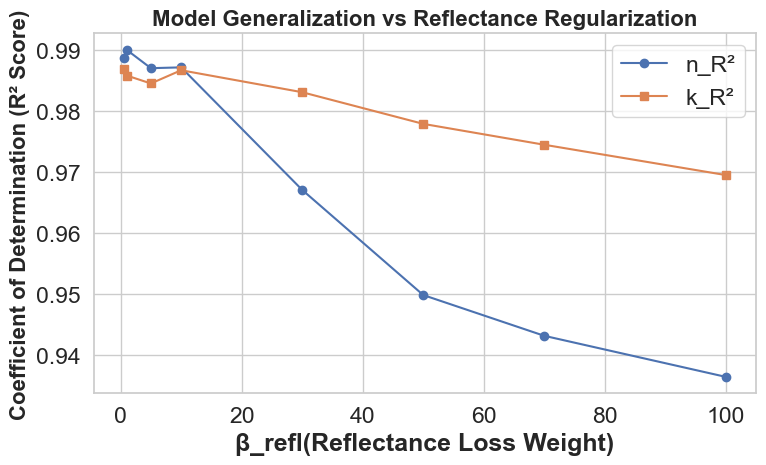

In [63]:
plt.figure(figsize=(8, 5))
plt.plot(results_df['λ_refl'], results_df['n_R²'], label='n_R²', marker='o')
plt.plot(results_df['λ_refl'], results_df['k_R²'], label='k_R²', marker='s')
plt.xlabel('β_refl(Reflectance Loss Weight)', fontsize=18, fontweight='bold')
plt.ylabel('Coefficient of Determination (R² Score)', fontsize=16, fontweight='bold')
plt.title('Model Generalization vs Reflectance Regularization', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "Model_Generalization_vs Reflectance_Regularization.png"))
plt.show()


## Predicted vs True plots (for best λ)

In [49]:
from sklearn.preprocessing import MinMaxScaler

# Step 1: Normalize each metric (so they're on the same scale)
metrics_to_combine = ['n_MAE', 'k_MAE', 'n_RMSE', 'k_RMSE', 'n_R²', 'k_R²']
scaler = MinMaxScaler()

# Invert R² so lower is better for scoring consistency
results_df['n_invR2'] = 1 - results_df['n_R²']
results_df['k_invR2'] = 1 - results_df['k_R²']

# Re-define combined list with inversed R²
metrics_to_combine = ['n_MAE', 'k_MAE', 'n_RMSE', 'k_RMSE', 'n_invR2', 'k_invR2']

# Normalize all selected metrics
normalized_metrics = scaler.fit_transform(results_df[metrics_to_combine])
results_df['composite_score'] = normalized_metrics.mean(axis=1)  # equal weights

# Step 2: Find best λ_refl (lowest composite score)
best_idx = results_df['composite_score'].idxmin()
best_lambda = results_df.loc[best_idx, 'λ_refl']

print(f"Best λ_refl (based on all normalized metrics): {best_lambda:.3f}")


Best λ_refl (based on all normalized metrics): 0.500


### learning lambda

In [69]:
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam

# === Optional Scheduler Callback ===
class LambdaWarmupScheduler(Callback):
    def __init__(self, model, max_lambda=5.0, total_epochs=100):
        super().__init__()
        self.model_ref = model
        self.max_lambda = max_lambda
        self.total_epochs = total_epochs

    def on_epoch_begin(self, epoch, logs=None):
        if hasattr(self.model_ref, 'update_lambda'):
            self.model_ref.update_lambda(epoch, total_epochs=self.total_epochs, max_lambda=self.max_lambda)
            print(f"→ Epoch {epoch+1}: λ_refl updated to {self.model_ref.lambda_refl:.4f}")

# === User Options ===
use_combined_loss = True           # Use custom reflectance loss or not
use_scheduled_lambda = True        # Whether to schedule λ from 0 to max
lambda_refl_value = 0.0            # Used only if scheduling is False
max_lambda_refl = 30.0              # Final λ if using scheduling
total_epochs = 100

# === Build Model ===
base_model = build_mlp()

if use_combined_loss:
    print("Using custom combined loss with reflectance term.")

    # Wrap with custom model class
    model = ReflectanceModel(base_model, lambda_refl=lambda_refl_value)
    model.compile(optimizer=Adam(0.001))

    # Define training targets
    y_train_target = {
        'n_output': y_n_train,
        'k_output': y_k_train
    }

    # Set up callbacks
    callbacks = [EarlyStopping(patience=10, restore_best_weights=True)]
    if use_scheduled_lambda:
        lambda_scheduler = LambdaWarmupScheduler(model, max_lambda=max_lambda_refl, total_epochs=total_epochs)
        callbacks.append(lambda_scheduler)

else:
    print("Using standard per-output MSE loss.")
    
    model = base_model
    model.compile(
        optimizer=Adam(0.001),
        loss={'n_output': 'mse', 'k_output': 'mse'},
        metrics={'n_output': 'mae', 'k_output': 'mae'}
    )

    y_train_target = {
        'n_output': y_n_train,
        'k_output': y_k_train
    }

    callbacks = [EarlyStopping(patience=10, restore_best_weights=True)]

# Prepare input tensors
X_train_tensor = {
    'wavelength': X_train_scaled['Wavelength (µm)'].values.reshape(-1, 1),
    'material_id': X_train_scaled['material_id'].values.reshape(-1, 1),
    'group_id': X_train_scaled['group_id'].values.reshape(-1, 1)
}

X_test_tensor = {
    'wavelength': X_test_scaled['Wavelength (µm)'].values.reshape(-1, 1),
    'material_id': X_test_scaled['material_id'].values.reshape(-1, 1),
    'group_id': X_test_scaled['group_id'].values.reshape(-1, 1)
}

# === Train the Model ===
history = model.fit(
    X_train_tensor,
    y_train_target,
    validation_split=0.1,
    epochs=total_epochs,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)


Using custom combined loss with reflectance term.
Epoch 1/100
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - k_output_mae: 1.5301 - loss: 81.9665 - n_output_mae: 1.1174 - val_k_output_mae: 0.7696 - val_loss: 5.9324 - val_n_output_mae: 0.6014
Epoch 2/100
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - k_output_mae: 0.7838 - loss: 6.7489 - n_output_mae: 0.6056 - val_k_output_mae: 0.6825 - val_loss: 3.8374 - val_n_output_mae: 0.5215
Epoch 3/100
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - k_output_mae: 0.7056 - loss: 4.9084 - n_output_mae: 0.5298 - val_k_output_mae: 0.6589 - val_loss: 3.5663 - val_n_output_mae: 0.4953
Epoch 4/100
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - k_output_mae: 0.6803 - loss: 4.5053 - n_output_mae: 0.5127 - val_k_output_mae: 0.6647 - val_loss: 3.7192 - val_n_output_mae: 0.4933
Epoch 5/100
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - k_output_mae: 0.6689 - loss: 4.4783 - n_output_mae: 0.5086 - val_k_output_mae: 0.6673 - val_loss: 3.2559 - val_n_output_mae: 0.4875


In [70]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on test data
y_n_pred, y_k_pred = model.predict(X_test_tensor)
y_n_pred = y_n_pred.flatten()
y_k_pred = y_k_pred.flatten()
y_n_true = y_n_test.to_numpy().flatten()
y_k_true = y_k_test.to_numpy().flatten()

# === Compute Metrics ===
n_mae = mean_absolute_error(y_n_true, y_n_pred)
k_mae = mean_absolute_error(y_k_true, y_k_pred)

n_rmse = np.sqrt(mean_squared_error(y_n_true, y_n_pred))
k_rmse = np.sqrt(mean_squared_error(y_k_true, y_k_pred))

n_r2 = r2_score(y_n_true, y_n_pred)
k_r2 = r2_score(y_k_true, y_k_pred)

# === Print Results ===
print("\n📊 Test Metrics:")
print(f"n_MAE   = {n_mae:.5f}")
print(f"k_MAE   = {k_mae:.5f}")
print(f"n_RMSE  = {n_rmse:.5f}")
print(f"k_RMSE  = {k_rmse:.5f}")
print(f"n_R²    = {n_r2:.5f}")
print(f"k_R²    = {k_r2:.5f}")


3034/3034 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step

📊 Test Metrics:
n_MAE   = 0.34234
k_MAE   = 0.41793
n_RMSE  = 0.86386
k_RMSE  = 1.45870
n_R²    = 0.99000
k_R²    = 0.98656


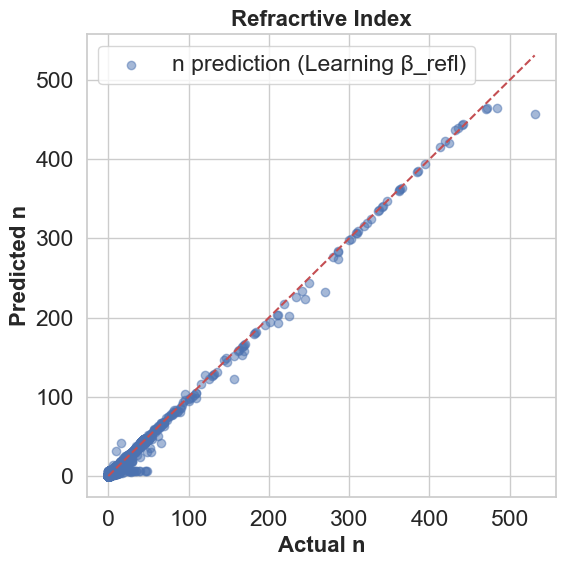

In [71]:
# Plot: n - predicted vs true
plt.figure(figsize=(6, 6))
plt.scatter(y_n_true, y_n_pred, alpha=0.5, label='n prediction (Learning β_refl)')
plt.plot([y_n_true.min(), y_n_true.max()], [y_n_true.min(), y_n_true.max()], 'r--')
plt.xlabel("Actual n", fontsize=16, fontweight='bold')
plt.ylabel("Predicted n", fontsize=16, fontweight='bold')
plt.title("Refracrtive Index", fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "n_pred_vs_true.png"))
#plt.close()
plt.show()

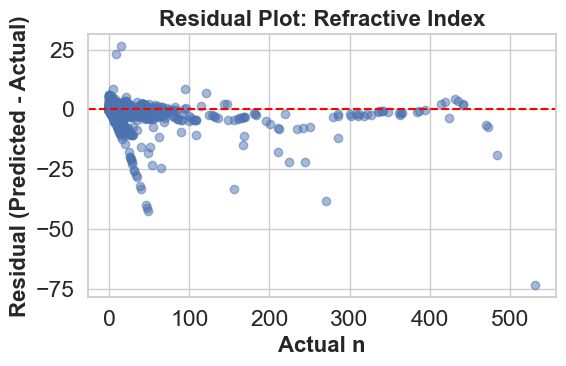

In [72]:
residuals = y_n_pred - y_n_true
plt.figure(figsize=(6, 4))
plt.scatter(y_n_true, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual n", fontsize=16, fontweight='bold')
plt.ylabel("Residual (Predicted - Actual)", fontsize=16, fontweight='bold')
plt.title("Residual Plot: Refractive Index",fontsize=16, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "n_residuals.png"))
plt.show()


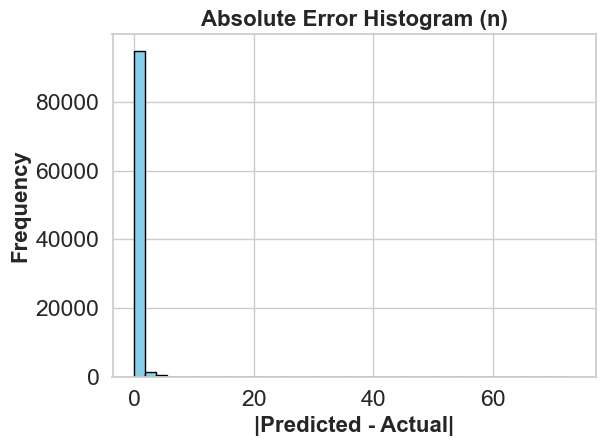

In [73]:
errors = np.abs(y_n_pred - y_n_true)
plt.hist(errors, bins=40, color='skyblue', edgecolor='black')
plt.title("Absolute Error Histogram (n)", fontsize=16, fontweight='bold')
plt.xlabel("|Predicted - Actual|", fontsize=16, fontweight='bold')
plt.ylabel("Frequency", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "n_error_histogram.png"))
plt.show()


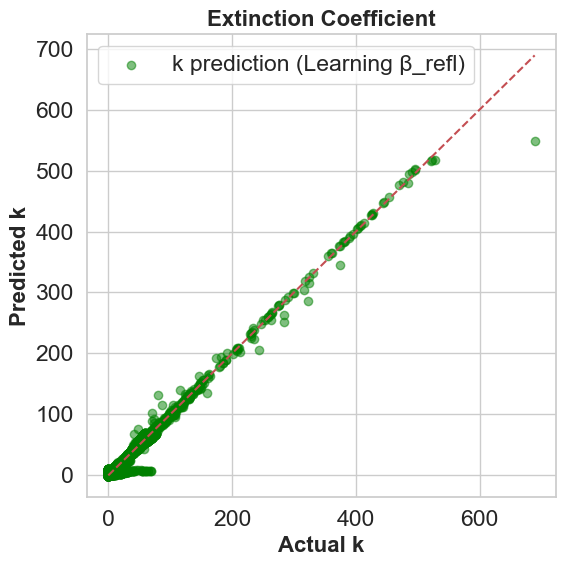

In [74]:
# Plot: k - predicted vs true
plt.figure(figsize=(6, 6))
plt.scatter(y_k_true, y_k_pred, alpha=0.5, color='green', label='k prediction (Learning β_refl)')
plt.plot([y_k_true.min(), y_k_true.max()], [y_k_true.min(), y_k_true.max()], 'r--')
plt.xlabel("Actual k", fontsize=16, fontweight='bold')
plt.ylabel("Predicted k", fontsize=16, fontweight='bold')
plt.title("Extinction Coefficient", fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "k_pred_vs_true.png"))
plt.show()

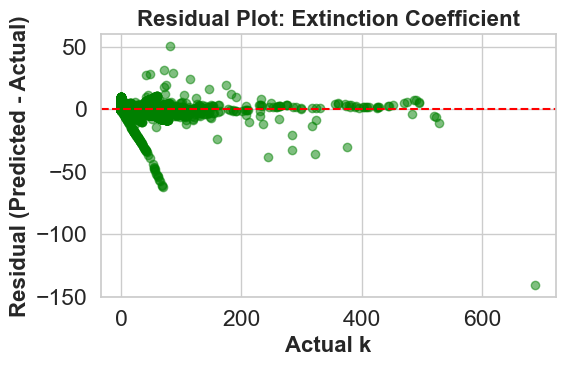

In [75]:
# Residual Plot for k
residuals_k = y_k_pred - y_k_true
plt.figure(figsize=(6, 4))
plt.scatter(y_k_true, residuals_k, color='green', alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual k", fontsize=16, fontweight='bold')
plt.ylabel("Residual (Predicted - Actual)", fontsize=16, fontweight='bold')
plt.title("Residual Plot: Extinction Coefficient",fontsize=16, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "k_residuals.png"))
plt.show()


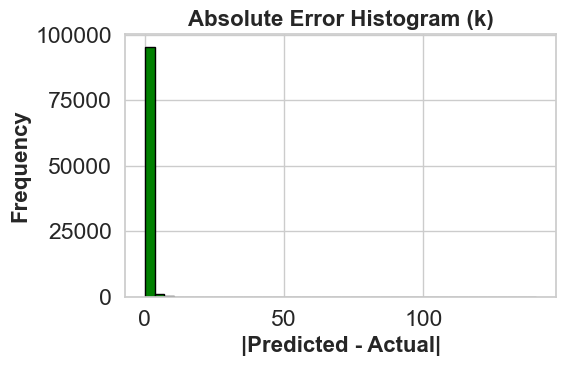

In [76]:
# Absolute Error Histogram for k
errors_k = np.abs(y_k_pred - y_k_true)
plt.figure(figsize=(6, 4))
plt.hist(errors_k, bins=40, color='green', edgecolor='black')
plt.title("Absolute Error Histogram (k)", fontsize=16, fontweight='bold')
plt.xlabel("|Predicted - Actual|", fontsize=16, fontweight='bold')
plt.ylabel("Frequency", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "k_error_histogram.png"))
plt.show()


In [59]:
# Save base_model for inference/inverse design
base_model.save("F:/Project_RINFO/models/base_model.keras")

# Save full model weights (not the class structure!)
model.save_weights("F:/Project_RINFO/models/refl_model.weights.h5")
